Matching spectra for *a*-opic irradiance with STLAB
===================================================

When designing stimuli with STLAB, you may need to find the settings that most closely match a spectrum you measured elsewhere, which requires some linear algebra. In this example we are aiming to match the spectral output of a NeurOptics PLR-3000 automated pupillometer, which administers light stimuli with 4 white LEDs. We measured the spectral output of the PLR-3000 with an OceanOptics STS-VIS spectrometer at the usual eye position and calibrated using our [standard pipeline](04c_integrating_sphere.ipynb#Calibration).

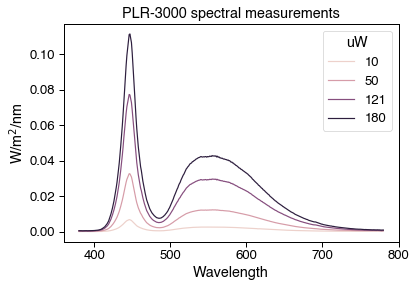

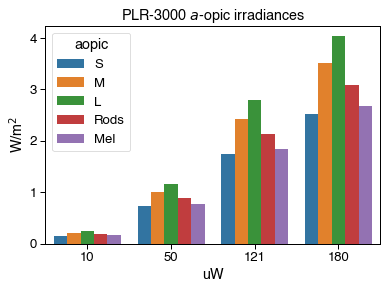

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_context('paper', font_scale=1.5)

from pyplr.CIE import get_CIES026

# Load data
plr3000 = pd.read_csv(
    '../data/PLR-3000_oo_calibrated_spectra.csv', index_col='uW')
plr3000.columns = plr3000.columns.astype('int')

# Plot spectra
specs = (plr3000.reset_index()
                .melt(id_vars='uW', 
                      var_name='Wavelength', 
                      value_name='w/m2/nm')
                .sort_values(['uW','Wavelength'])
                .reset_index(drop=True))
ax = sns.lineplot(
    data=specs, 
    x='Wavelength',
    y='w/m2/nm', 
    units='uW', 
    hue='uW', 
    estimator=None)
ax.set_ylabel('W/m$^2$/nm')
ax.set_title('PLR-3000 spectral measurements')

# Plot a-opic irradiances
sss = get_CIES026(asdf=True)
sss = sss.fillna(0)
plr_3k_ao = plr3000.dot(sss)
data = (plr_3k_ao.reset_index()
                 .melt(id_vars=['uW'], 
                       var_name=['aopic'], 
                       value_name='irradiance'))
f2, ax2 = plt.subplots()
sns.barplot(
    data=data, x='uW', y='irradiance', hue='aopic', ax=ax2)
ax2.set_ylabel('W/m$^2$')
ax2.set_title('PLR-3000 $a$-opic irradiances');

In [2]:
plr3000

,380,381,382,383,384,385,386,387,388,389,...,771,772,773,774,775,776,777,778,779,780
uW,,,,,,,,,,,,,,,,,,,,,
180,0.000511,0.000523,0.000502,0.000499,0.000441,0.000464,0.000478,0.000451,0.000485,0.000540,...,0.000946,0.000997,0.000946,0.000933,0.000961,0.000909,0.000863,0.000873,0.000858,0.000899
121,0.000408,0.000364,0.000368,0.000423,0.000379,0.000359,0.000381,0.000354,0.000381,0.000389,...,0.000658,0.000705,0.000681,0.000642,0.000662,0.000624,0.000639,0.000550,0.000609,0.000622
50,0.000217,0.000215,0.000228,0.000224,0.000217,0.000219,0.000197,0.000217,0.000225,0.000205,...,0.000555,0.000568,0.000574,0.000582,0.000573,0.000578,0.000577,0.000513,0.000592,0.000592
10,0.000039,0.000001,0.000033,0.000030,0.000049,0.000051,0.000040,0.000060,0.000048,0.000030,...,0.000181,0.000175,0.000186,0.000192,0.000181,0.000194,0.000194,0.000125,0.000198,0.000193


In order to find the right STLAB settings, we need to make a `CalibrationContext` from our calibrated OceanOptics data.

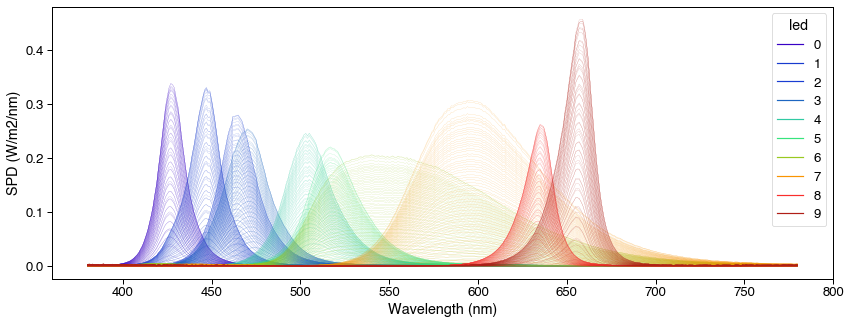

In [3]:
from pyplr.calibrate import CalibrationContext

cc = CalibrationContext(
    '../data/S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()

Now we can start searching for the STLAB settings that match the PLR-3000 settings for *a*-opic irradiance. We will focus on the 180 uW setting to keep things simple. For all possible combinations in 10 choose 5 (one LED for each photoreceptor class), we use linear algebra to work out the input fraction of the chosen LEDs that is required for matching the spectrum. Only those solutions where the input fractions are between 0 and 1 are valid, because eventually we will need to convert these to 12-bit integers for STLAB.  

In [4]:
import itertools

import numpy as np

# The PLR-3000 setting we care about
uW_setting = 180

# Photoreceptors classes we are aiming to match
opsins = ['L','M','S','Mel', 'Rods']

# An LED for each photoreceptors
num_leds = 5

# List to store valid settings
keep = []

# Loop through all possible combinations in 10 choose 5
for choose in itertools.combinations(range(10), num_leds):
    
    # Get the irradiances for each LED at maximum
    settings_to_irradiances = cc.aopic.loc[[(led, 4095) for led in choose], opsins]
    
    # Take the inverse
    irradiances_to_settings = np.linalg.inv(settings_to_irradiances)
    
    # Calculate the required input fraction for the chosen LEDs
    plr_irradiances = plr_3k_ao.loc[uW_setting, opsins].T
    settings = plr_irradiances.dot(irradiances_to_settings)

    # Keep the settings where all values are greater than 0 and less then 1
    if all(settings < 1) and all(settings > 0):
        keep.append((uW_setting, choose, settings))
        
print('\n> ' + str(len(keep)) + ' settings found')
keep


> 18 settings found


[(180,
  (0, 1, 2, 6, 7),
  array([0.00517166, 0.32173031, 0.02026771, 0.19441607, 0.0164306 ])),
 (180,
  (0, 1, 2, 6, 8),
  array([0.31550785, 0.05958875, 0.10219134, 0.20210005, 0.06132067])),
 (180,
  (0, 1, 2, 6, 9),
  array([0.3583914 , 0.02262412, 0.11388467, 0.20229605, 0.07338902])),
 (180,
  (0, 1, 3, 6, 7),
  array([0.01684065, 0.31693341, 0.01842986, 0.19397591, 0.01666438])),
 (180,
  (0, 1, 3, 6, 8),
  array([0.40155686, 0.01397228, 0.09859531, 0.20033016, 0.06598839])),
 (180,
  (0, 2, 3, 6, 9),
  array([0.40011401, 0.06656192, 0.04605868, 0.20147622, 0.07599868])),
 (180,
  (0, 2, 4, 6, 7),
  array([0.41946373, 0.08731701, 0.04332805, 0.17244175, 0.02821919])),
 (180,
  (0, 2, 4, 6, 8),
  array([0.38995726, 0.11689858, 0.00506435, 0.200176  , 0.06646312])),
 (180,
  (0, 2, 4, 6, 9),
  array([0.38655782, 0.11954637, 0.00182771, 0.2016076 , 0.07561016])),
 (180,
  (0, 2, 5, 6, 7),
  array([0.40016009, 0.10775283, 0.05472756, 0.15665175, 0.03607427])),
 (180,
  (0, 2, 5, 6

So there are 18 solutions to the problem using 5 LEDs. Next, we need to convert the input fractions to 12-bit integers for STLAB.

In [5]:
# Lists to store settings and predicted spectra
settings = []
predicted = []

# Remove the index
keep = [val[1:] for val in keep if val[0]]

# Loop over settings
for k in keep:
    leds = k[0]
    
    # Convert to 12-bit integer and save LED settings
    intensities = np.round(k[1] * 4095).astype('int')
    spec = [0]*10
    for led, i in zip(leds, intensities):
        spec[led] = i
        
    # Get predicted spectrum
    pred = cc.predict_spd(spec)
    
    # Add to lists
    settings.append(spec) 
    predicted.append(pred)

# Make DFs
settings = pd.DataFrame(settings)
predicted = pd.concat(predicted)
predicted.reset_index(inplace=True, drop=True)

# In theory it doesn't matter which one we use, but let's define
# the 'best' solution as the one with the least squared error
best = predicted.sub(
    plr3000.loc[uW_setting].to_numpy()).pow(2).sum(axis=1).idxmin()

optimal_predicted = predicted.loc[best]
optimal_settings = settings.loc[best]

In [6]:
optimal_settings

0      21
1    1317
2      83
3       0
4       0
5       0
6     796
7      67
8       0
9       0
Name: 0, dtype: int64

In [7]:
from scipy.interpolate import interp1d

class Problem:
    def __init__(self, stlab_aopic, plr_3000_aopic, scalar=121):
        self.stlab_aopic = stlab_aopic
        self.plr_3000_aopic = plr_3000_aopic
        self.scalar = scalar
    
    def smlri_calculator(self, x0):
        smlri = 0
        for led in [0,1,2,6,7]:
            x = self.stlab_aopic.loc[led].index/4095
            y = self.stlab_aopic.loc[led]
            # sometimes x_new is outside the interpolation 
            # range so we extrapolate to avoid error
            f = interp1d(x, y, axis=0, fill_value='extrapolate')
            smlri += f(x0[led])
        return pd.Series(smlri, index=self.stlab_aopic.columns)      
        
    def objective_function(self, x0):
        #'(lsmri_current - lmsri_desired).^2'
        smlri_current = self.smlri_calculator(x0)
        smlri_desired = self.plr_3000_aopic*(self.scalar/180)
        return -(smlri_current-smlri_desired).to_numpy() 
    


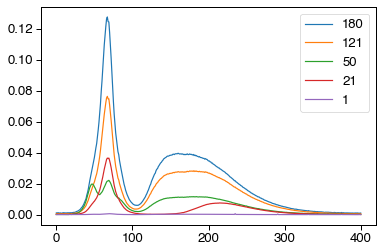

In [8]:
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from pyplr.CIE import get_CIES026


# random start (or can use best guess)
x0 = optimal_settings.to_numpy()/4095

# aopic data from original measurements
sss = get_CIES026(asdf=True)
sss.fillna(0, inplace=True)
aopic = cc.data.dot(sss)

new = {180: optimal_settings.to_list(),
       121: [],
       50: [],
       21: [],
       1: []}

for s in [121, 50, 21, 1]:
    # class to encapsulate the problem with the aopic data
    p = Problem(stlab_aopic=aopic, 
                plr_3000_aopic=plr_3k_ao.loc[180], 
                scalar=s)

    # define constraints and bounds
    bounds = Bounds(np.ones((10))*0, np.ones((10))*1)

    res = minimize(lambda x: sum(pow(p.objective_function(x), 2)), 
                   x0,
                   method='SLSQP',
                   bounds=bounds)
    
    # add solution to dict
    new[s] = list((res.x*4095).astype('int'))

# plot results
fig, ax = plt.subplots()
for k in new.keys():
    spec = cc.predict_spd(new[k]).to_numpy()[0]
    ax.plot(spec, label=k)
    
ax.legend()

- 

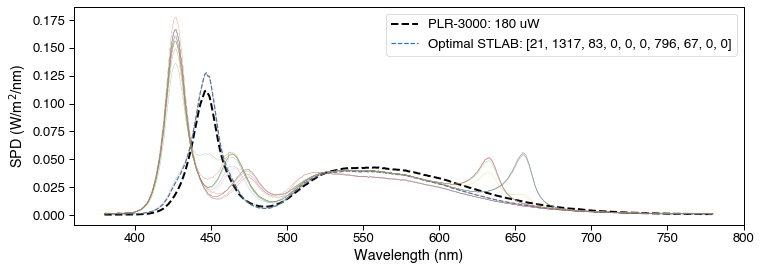

In [9]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(12,4))
plr3000.loc[uW_setting].plot(
    label='PLR-3000: {} uW'.format(
        uW_setting), ax=ax, color='k', lw=2, linestyle='--')
ax.plot(plr3000.columns, 
        optimal_predicted, 
        label='Optimal STLAB: ' + str(optimal_settings.to_list()), 
        linestyle='--')
ax.legend()
for idx, p in predicted.iterrows():
    p.plot(lw=.2)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('SPD (W/m$^2$/nm)')
fig.savefig('../img/PLR-3000-STLAB-stimuli.tiff', dpi=300, bbox_inches='tight')

All that remains is to make a video file for use with STLAB.

In [16]:
from pyplr.stlab import pulse_protocol, video_file_to_dict

for uW in new:
    pulse_protocol(pulse_spec=new[uW],
                   pulse_duration=1000,
                   fname=f'PLR-3000-{uW}-mw')

"PLR-3000-180-mw.dsf" saved in the current working directory.
"PLR-3000-121-mw.dsf" saved in the current working directory.
"PLR-3000-50-mw.dsf" saved in the current working directory.
"PLR-3000-21-mw.dsf" saved in the current working directory.
"PLR-3000-1-mw.dsf" saved in the current working directory.


In [17]:
uW

1